Firstly, download required data: the Friends quotes and FastText Common Crawl word vectors.
(Comment this once you download the files.)

In [0]:
!wget https://raw.githubusercontent.com/shilpibhattacharyya/Friends_Analysis/master/friends_dataset.csv
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip
!unzip crawl-300d-2M-subword.zip
!rm crawl-300d-2M-subword.zip
!rm crawl-300d-2M-subword.bin

Import necessary packages

In [41]:
import re
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport

from keras.utils import to_categorical, plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Embedding

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

I am only interested in three columns: *Speaker*, *Text* and *Season*.

In [15]:
full_data = pd.read_csv('friends_dataset.csv')
dialog_data = full_data[['Speaker', 'Text', 'Season']].copy()
print("{} missing lines out of {}".format(dialog_data.isnull()['Text'].sum(), dialog_data.shape[0]))
dialog_data.tail()

1511 missing lines out of 93335


,Speaker,Text,Season
93330,Chandler,What we did last night was....,4
93331,Chandler,I'm telling ya! It's gonna happen. Next year i...,10
93332,Ross,Yeah.,1
93333,Ross,What are you doing?,4
93334,Phoebe,"Oh we can't, we already have plans.",5


Have an idea about the distribution of lines per character.

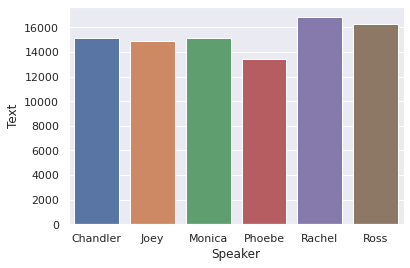

In [16]:
character_dialog = dialog_data.groupby(['Speaker']).count().reset_index()
ax = sns.barplot(x='Speaker', y='Text', data=character_dialog)
plt.show()

Have an idea about the distribution of lines per character per season.

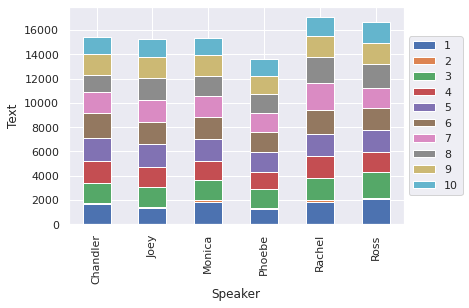

In [17]:
ax = dialog_data.groupby(['Speaker', 'Season']).size().unstack().plot(kind='bar', stacked=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Text')
plt.show()

## Data cleaning
Tokenization and lemmatization. Stopword removal may be a good idea but I chose to keep stop words in case their over/underuse is deterministic w.r.t. the language.
I also remove nan values.

In [18]:
lemmatizer = WordNetLemmatizer()
MIN_SENT_LEN = 3
def tokenize(raw_value, min_sent = MIN_SENT_LEN):
  """
  Take the raw_value, tokenize it, lowercase it and lemmatize it. 
  
  Parameters:
    raw_value: str - the string to tokenize
    min_sent: int - the mainimum length of the resulting tokenize sentence. 
                If not met, then return NaN.
  Return: str
      A tokenized value with words separated by single spaces
  """
  words = re.sub(r"[^A-Za-z]", " ", raw_value).lower().split()
  words = [lemmatizer.lemmatize(word.strip()) for word in words]
  if len(words) < min_sent:
    return np.nan
  return " ".join(words)

# Let's tokenize and clean the data
characters = list(set(dialog_data['Speaker'].tolist()))
dialog_data['Text'] = dialog_data['Text'].astype(str).apply(tokenize)
dialog_data = dialog_data.drop(dialog_data[dialog_data['Text'].isna()].index)
dialog_data['Speaker'] = dialog_data['Speaker'].astype(str).apply(lambda txt: int(characters.index(txt)))
dialog_data.head()

,Speaker,Text,Season
1,1,oh you got the whole night huh,1
2,2,phoebe is going to say yes that s that s great,9
5,5,doe this look like something the girlfriend of...,3
8,2,what that s terrible,9
9,0,rachel and joey it s rachel and joey,10


Load the pre-trained vectors. Only the words from the given vocabulary (which in this case is a *word: word_id* dictionary) are loaded as a matrix.

In [0]:
def load_vectors(fname, vocabulary):
    """
    Load pre-trained vectors for the words in the vocabulary.
    Return a matrix of vectors with each row corresponding to a word.
    """
    vocabulary_set = set(vocabulary.keys())
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    vector_matrix = np.zeros((len(vocabulary_set) + 1, d), dtype=np.float)
    for line in fin:
        tokens = line.rstrip().split(' ')
        if tokens[0] in vocabulary_set:
          vector_matrix[vocabulary[tokens[0]]] = np.array(tokens[1:], dtype=np.float)
    return vector_matrix

Generate training data using a CBOW architecture where the context of a word is given by its surrounding words. 

In [0]:
def training_data_creator(tokenized_data, expected_labels, window_size=2):
  """
  Create CBOW sequences where each word is characterized by a context defined by the surrounding words.
  
  Parameters:
      tokeinzed_data: iterable - the tokenized sentences
      expected_labels: int - the expected number of labels/classes
      window_size: int - the number of context words to consider at each left and right of the word.
  Return: tuple
      Sequence array and label array. Each sentence may result in multiple sequences.
  
  """
  contexts = []
  labels = []
  for seq in tokenized_data:
    for idx, word in enumerate(seq):
      left_boudary = idx - window_size
      right_boudary = idx + window_size + 1
      contexts.append([seq[i] for i in range(left_boudary, right_boudary) if 0 <= i < len(seq) and i != idx])
      labels.append(word)
  X = pad_sequences(contexts, maxlen=window_size*2)
  y = to_categorical(labels, expected_labels)
  return X, y

## Language models
Create a CBOW model for each character starting from pre-trained embeddings. Note that the FastText embeddings are modified during training to better reflect the current contexts.

### Network parameters:
- The architecture, although simple, gave the best results when compred with other more complex ones.
- The number of LSTM nodes didn't seem to impact results by much.
- The activation and loss functions are common choices in these kind of settings.
- The number of epochs could potentially be increased.
- The batch size seems to have an important role in the overall accuracy so using a lower value may improve results. I tried to keep a balance between training time and ite value.

In [0]:
WIN_SIZE = 2
for friend in characters:
  print(friend)
  corpus_train = dialog_data[(dialog_data['Speaker'] == characters.index(friend)) 
  & (dialog_data['Season'].isin([1,2,3,4,5,6,7,8]))]['Text'].tolist()
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus_train)
  tokenized_data = tokenizer.texts_to_sequences(corpus_train)
  vector_matrix = load_vectors('crawl-300d-2M-subword.vec', tokenizer.word_index)
  X_train, y_train = training_data_creator(tokenized_data, len(tokenizer.word_index)+1)

  model = Sequential()
  model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=vector_matrix.shape[1], 
                      weights=[vector_matrix], input_length=WIN_SIZE*2, trainable=True))
  model.add(LSTM(100, activation='relu', input_shape=(WIN_SIZE*2, vector_matrix.shape[1]), return_sequences=False))
  model.add(Dense(len(tokenizer.word_index)+1, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  model.fit(X_train, y_train, epochs=30, verbose=1, batch_size=64)

  model.save(friend + '_model.seq')

Once the language models are trained, extract the word embeddings. The training corpus is toknized one more time to obtain the keys for a *word: vector* dictionary.

In [0]:
embeddings = []
for friend in characters:
  corpus_train = dialog_data[(dialog_data['Speaker'] == characters.index(friend)) & 
                             (dialog_data['Season'].isin([1,2,3,4,5,6,7,8]))]['Text'].tolist()
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus_train)

  model = load_model(friend + '_model.seq')
  embeddings_model = model.layers[0].get_weights()[0]
  embeddings.append({w: embeddings_model[tokenizer.word_index[w]] 
                     for w in tokenizer.word_index.keys() 
                     if tokenizer.word_index[w] < len(embeddings_model)})

This is how the NN architecture looks like.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


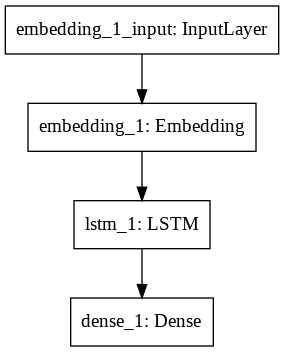

In [45]:
plot_model(model)

## Quote prediction
Firstly, define a transformer that uses the above-learned word embeddings to generate quote embeddings.
Each quote embedding is the character embedding mean of all the constituent words.
The final feature vector is the concatenation of all character feature vectors.

In [0]:
class FriendsTransformer(BaseEstimator, TransformerMixin):
  """
  Transform the lines of a given character in vectors using pre-trained embeddings.
  """
  def __init__(self, vectors, dimensions):
    """
    Create a new transformer instance.
    Parameters:
        vectors: iterable - an iterable of dictionaries. Each dict contains word: embeddings associations.
        dimensions: int - the expected size of each embedding vector
    """
    self._vectors = vectors
    self._dimensions = dimensions

  def fit(self, X, y=None):
    """
    This is a transformer, so no need for fit.
    """
    return self

  def transform(self, X):
    """
    Transform each given sequence into an embedding vector.
    For each friend, firstly extract the embedding of each word from the sequence and average the results.
    Then, concatenate all friend embeddings.
    """
    X_transformed = []
    for item in X:
      item_vector = np.array([])
      for i, friend in enumerate(self._vectors):
        item_vector = np.concatenate((item_vector, np.mean([self._vectors[i].get(w, np.zeros(self._dimensions, dtype=np.float)) 
        for w in item.split(' ')], axis=0)))
      X_transformed.append(item_vector)
    return np.array(X_transformed)


Then, create a pipeline to transform and fit data from Seasons 9 and 10 (different from the data used to train the language models).
For visualization purposes, use yellowbricks.

Why Precision, Recall and F1-score?

- **Precision**: is the proportion of lines *correctly* attributed to a each character. Intuitively, precision is the ability of the quote classifier not to attribute to a character a quote that is not said by that character.
- **Recall**: is the proportion of lines *correctly* attributed to a each character from all possible lines for that character. Intuitively, recall reflects the ability of the classifier to find all the right character-quote associations.
- **F1-score**: provides a single score that balances both the concerns of precision and recall in one number.

Overall, these metrics provide a image of the *relevance* of the predictions w.r.t. our goal of identifying the character of a given quote.

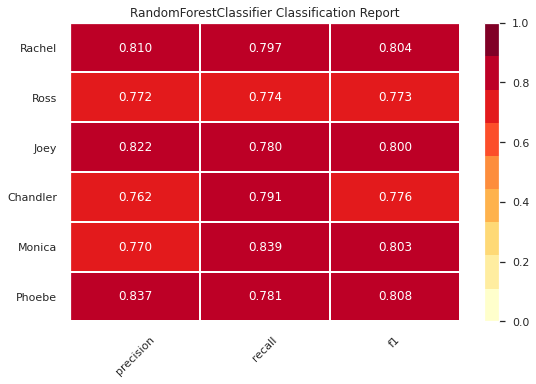

In [40]:
corpus_train = dialog_data[dialog_data['Season'].isin([9, 10])][['Speaker','Text']]
ft = FriendsTransformer(embeddings, 300, characters)
classifier = RandomForestClassifier(n_estimators=200)
pipeline = Pipeline([('transformer', ft), ('classifier', classifier)])
X_train, X_test, y_train, y_test = train_test_split(corpus_train['Text'].tolist(), 
                                                    corpus_train['Speaker'].tolist(), 
                                                    test_size=0.25, random_state=42)

# Using the awesome classification report from yellowbricks
visualizer = ClassificationReport(pipeline, classes=characters)
visualizer.fit(X_train, y_train) # fit the pipeline and the visualizer        
visualizer.score(X_test, y_test) # evaluate the predictions
visualizer.poof()   

# print(classification_report(y_test, y_pred, target_names=characters))

A confusion matrix may be useful here.

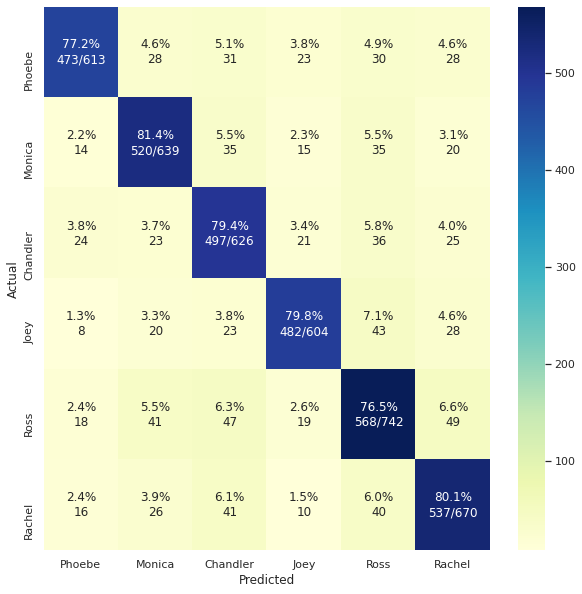

In [35]:
def plot_cm(y_true, y_pred, labels, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=[labels[i] for i in np.unique(y_true)], columns=[labels[i] for i in np.unique(y_true)])
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

y_pred = pipeline.predict(X_test)
plot_cm(y_test, y_pred, characters)

Finally, let's play guess the FRIEND.

In [53]:
line = "Don't you put words in people's mouths. You put turkey in people's mouths."
characters[pipeline.predict([tokenize(line)])[0]]

'Joey'